In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

import torchvision
import torchvision.transforms as tr
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from tqdm import tqdm

import imageio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import copy
import urllib.request

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"

# Recurrent Neural Network

## LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import os
import locale

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def convert_to_float(df):
   df_np = df.values
   for i in range(df_np.shape[0]):
      for j in range(1, df_np.shape[1]):
         df_np[i, j] = locale.atof(df_np[i, j])

   rst = pd.DataFrame(df_np)
   rst.columns = df.columns
   return rst

In [ ]:
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
scaler = MinMaxScaler()

DATA_DIR = "/content/drive/MyDrive/datasets/bitcoin"
DATA_NAME = "BTC_CHART_DATASET.csv"
DATA_PATH = os.path.join(DATA_DIR, DATA_NAME)

column_names = ["종가", "오픈", "고가", "저가", "변동 %"]

BTC_DATA = convert_to_float(pd.read_csv(DATA_PATH)[:-2])
BTC_DATA = BTC_DATA.iloc[::-1]
BTC_DATA[column_names] = scaler.fit_transform(BTC_DATA[column_names])
BTC_DATA

,날짜,종가,오픈,고가,저가,변동 %
3688,2012년 02월 02일,0.000028,0.000028,0.000028,0.000029,0.518095
3687,2012년 02월 03일,0.000027,0.000027,0.000026,0.000027,0.482712
3686,2012년 02월 04일,0.000025,0.000025,0.000025,0.000026,0.493341
3685,2012년 02월 05일,0.000022,0.000022,0.000022,0.000023,0.472353
3684,2012년 02월 06일,0.000018,0.000018,0.000017,0.000018,0.456881
...,...,...,...,...,...,...
4,2022년 03월 09일,0.621401,0.573930,0.617938,0.583193,0.624916
3,2022년 03월 10일,0.584319,0.621426,0.610335,0.582492,0.433338
2,2022년 03월 11일,0.573634,0.584319,0.583624,0.576317,0.489035
1,2022년 03월 12일,0.574808,0.573634,0.571566,0.582989,0.516346


In [ ]:
#X = BTC_DATA[["오픈","고가","저가","변동 %"]].values
#y = BTC_DATA["종가"].values

X = BTC_DATA[column_names].values

device = "cuda" if torch.cuda.is_available() else "cpu"

def seq_data(x, seq_len):
   x_seq = []
   y_seq = []
   for i in range(len(x) - seq_len):
      x_seq.append(x[i:i+seq_len])
      y_seq.append(x[i+seq_len])

   return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device)

#def seq_data(x, y, seq_len):
#   x_seq = []
#   y_seq = []
#   for i in range(len(x) - seq_len):
#      x_seq.append(x[i:i+seq_len])
#      y_seq.append(y[i+seq_len])
#
#   return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)

In [ ]:
split = 3300
sequence_length = 5
x_seq, y_seq = seq_data(X, sequence_length)
#x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  from ipykernel import kernelapp as app


torch.Size([3300, 5, 5]) torch.Size([3300, 5])
torch.Size([384, 5, 5]) torch.Size([384, 5])


In [ ]:
train_data = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test_data = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size)

In [ ]:
input_size = x_seq.size(2)
num_layers = 5
hidden_size = 32

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/models/torch_basic_study/stock_predictor.pt"

In [ ]:
class LSTM(nn.Module):
   def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
      super(LSTM, self).__init__()
      self.device = device
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
      self.fc = nn.Linear(hidden_size*sequence_length, 5)
   
   def forward(self, x):
      h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
      c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
      out, _ = self.lstm(x, (h0, c0))
      out = out.reshape(out.shape[0], -1)
      out = self.fc(out)
      return out

In [ ]:
model = LSTM(input_size=input_size, 
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers=num_layers,
             device=device).to(device)
#model.load_state_dict(torch.load(MODEL_PATH))
criterion = nn.MSELoss()
num_epochs = 401
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
loss_graph = []
data_length = len(train_loader)

for epoch in range(num_epochs):
   running_loss = 0.0

   for data in train_loader:
      seq, target = data
      out = model(seq)
      loss = criterion(out, target)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

   loss_graph.append(running_loss / data_length)
   if epoch % 100 == 0:
      print("[epoch: %d] loss: %.8f" %(epoch, running_loss / data_length))

[epoch: 0] loss: 0.00833875
[epoch: 100] loss: 0.00074340
[epoch: 200] loss: 0.00073431
[epoch: 300] loss: 0.00062586
[epoch: 400] loss: 0.00050174


In [ ]:
#torch.save(model.state_dict(), MODEL_PATH)

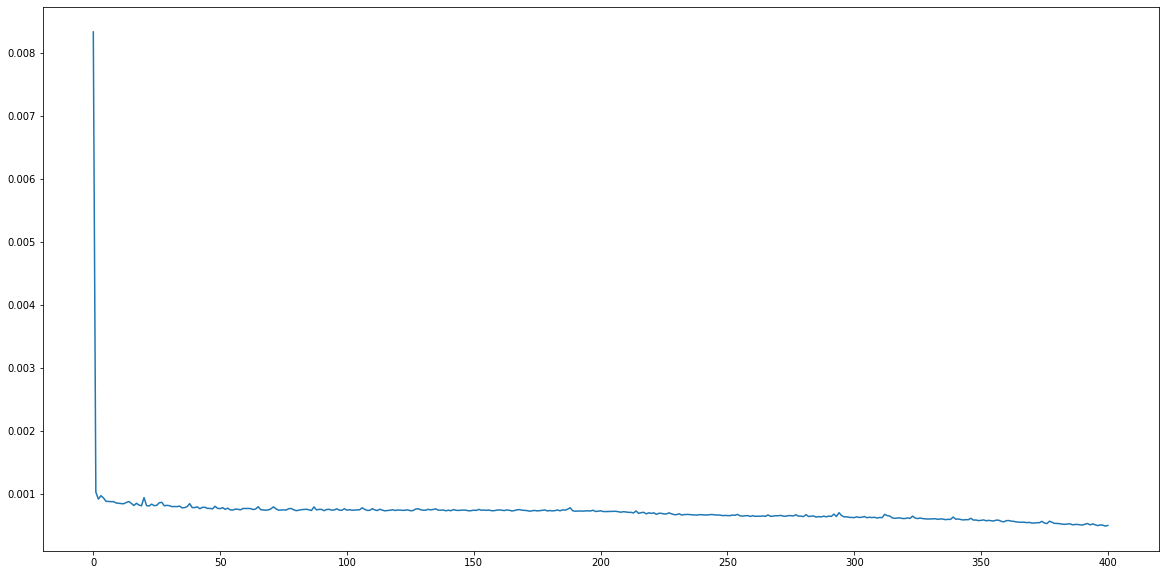

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

In [ ]:
concat_data = torch.utils.data.ConcatDataset([train_data, test_data])
oneday_data_loader = torch.utils.data.DataLoader(dataset=concat_data, batch_size=100)
continuous_data_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=100)

with torch.no_grad():   
   model.eval()
   oneday_pred = []
   for data in oneday_data_loader:
      seq, target = data
      out = model(seq)
      oneday_pred += out.cpu().tolist()

   continuous_pred = []
   for data in continuous_data_loader:
      seq, target = data
      out = model(seq)
      continuous_pred += out.cpu().tolist()
   for _ in range(3684 - split):
      seq = torch.cat([seq[-1][1:], out[-1].unsqueeze(0)], axis=0).unsqueeze(0)
      out = model(seq)
      continuous_pred += out.cpu().tolist()

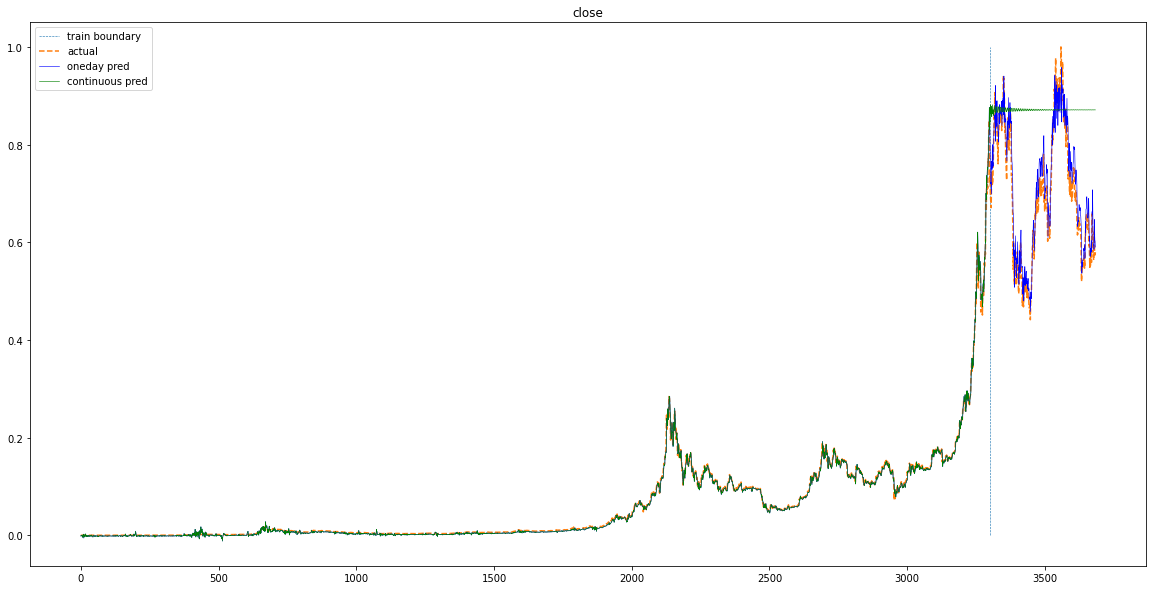

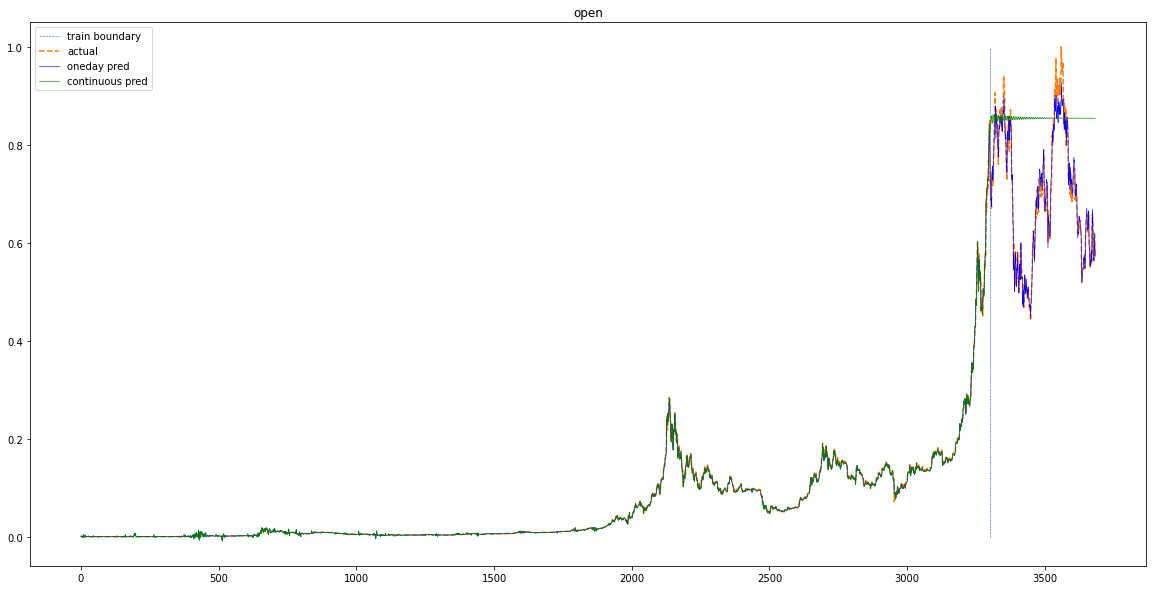

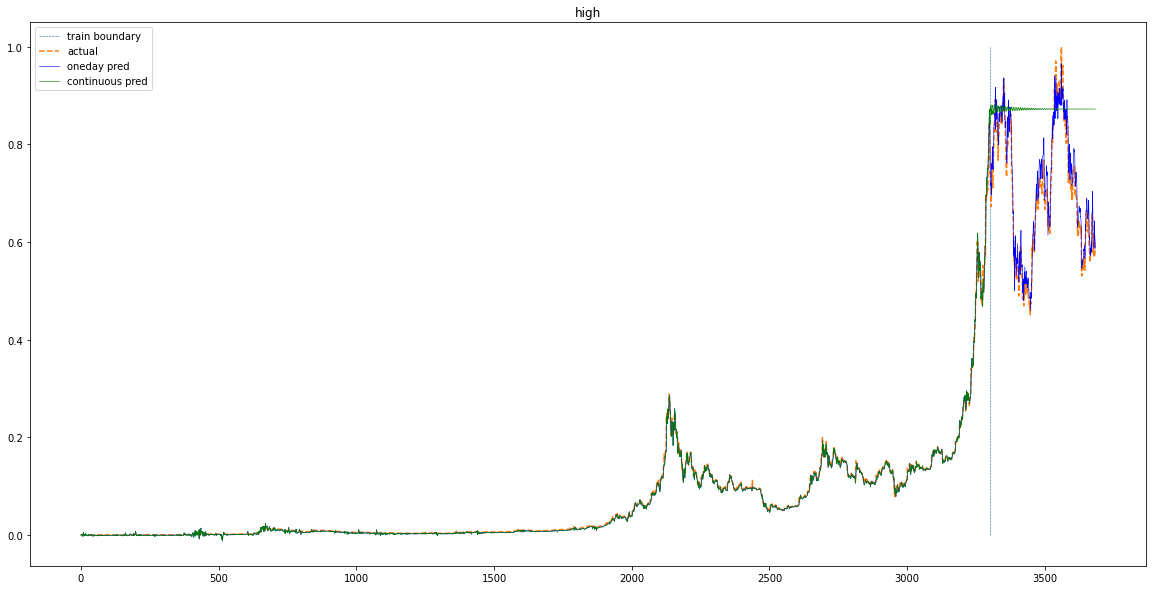

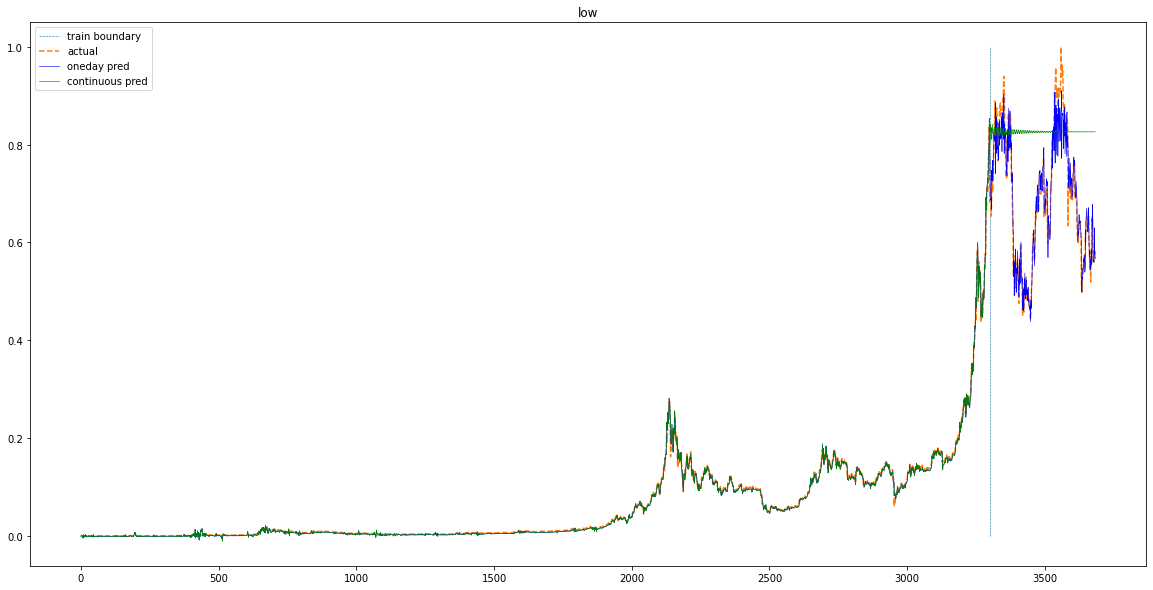

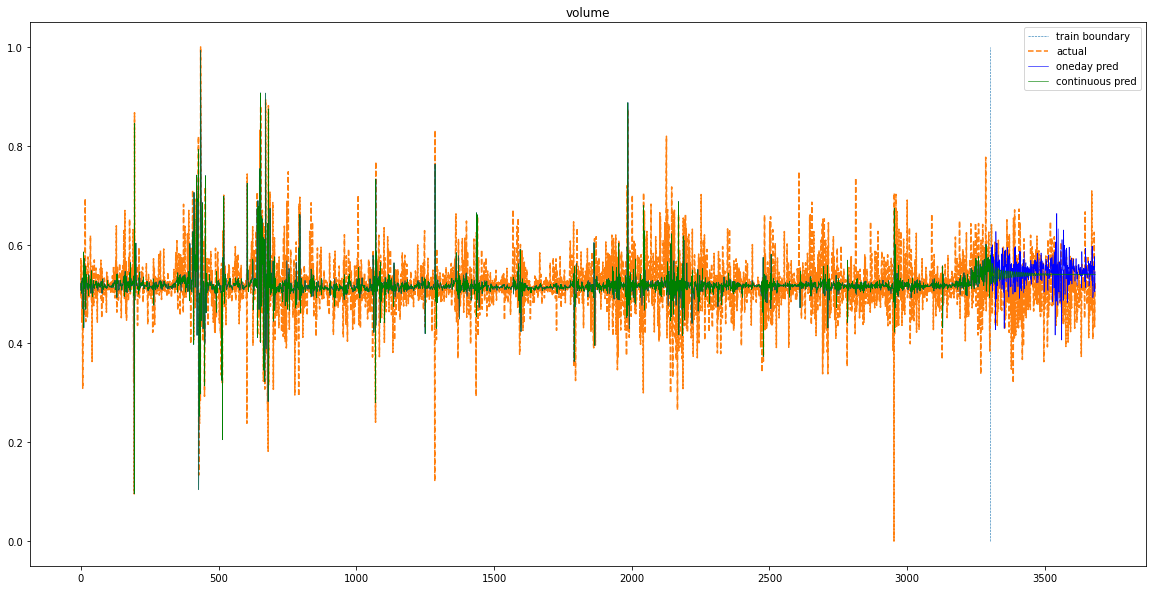

In [ ]:
title = ["close", "open", "high", "low", "volume"]
for idx, col in enumerate(column_names):
   plt.figure(figsize=(20, 10))
   plt.title(title[idx])
   plt.plot(np.ones(100)*len(train_data), np.linspace(0, 1, 100), '--', linewidth=0.6)
   plt.plot(BTC_DATA[col][sequence_length:].values, '--')
   plt.plot(np.array(oneday_pred)[:,idx], 'b', linewidth=0.6)
   plt.plot(np.array(continuous_pred)[:,idx], 'g', linewidth=0.6)
   plt.legend(["train boundary", "actual", "oneday pred", "continuous pred"])
   plt.show()